In [1]:
# Set up interactive plotting using matplotlib, and load numpy
# %pylab ipympl
%pylab inline
import warnings
warnings.filterwarnings('ignore')

# Introduction
In this notebook we will perform 3 common tasks: 

1. Obtain SMAP soil moisture data for a user-specified grid over a single date
2. Obtain SMAP soil moisture data for user-specified points over a range of dates
3. Obtain SMAP soil moisture data in its native coordinates
4. Export a pipeline for re-use elsewhere

# Setup

Make sure you have PODPAC installed with the **datatype** optional dependencies:

```
$ pip install podpac[datatype]
```

# SMAP Level-4 Data Access

## Provide Earth Data Login Credentials
If you do not have an earth data login, or have not activated OpenDAP access, follow the [instructions here](https://creare-com.github.io/podpac-docs/user/earthdata.html)

In [3]:
import getpass
username = password = None
username = input("Username:");   password = getpass.getpass('Password:')

Username: mpuecker
Password: ··················


## Create the PODPAC SMAP Node

In [4]:
import podpac
import podpac.datalib

# Create the SMAP node
product = 'SPL4SMAU'   # Level 4 soil moisture analysis update
sm = podpac.datalib.SMAP(product=product, interpolation='nearest', username=username, password=password)

#  Retrieve and plot SMAP data

* Set a particular date
* Over lat-lon range with user-specified grid

(-181.0, 181.0, -91.0, 91.0)

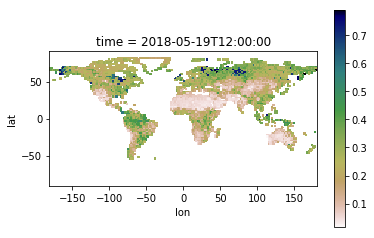

In [5]:
# dim = (start, stop, step)
lat =   (   90,  -90,-2.0)
lon =   ( -180,  180, 2.0)

time = '2018-05-19T12:00:00'

c_world = podpac.Coordinates([podpac.crange(*lat),
                              podpac.crange(*lon),
                              time], dims=['lat', 'lon', 'time'])
o = sm.eval(c_world)
o.plot(cmap='gist_earth_r')
axis('scaled')
pass

# Let's do the same thing without using PODPAC

### Create an authenticated session

In [6]:
# First create an authenticated session
import requests
class SessionWithHeaderRedirection(requests.Session):
    """
    Modified from: https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+Python
    overriding requests.Session.rebuild_auth to mantain headers when redirected
    
    Attributes
    ----------
    auth : tuple
        (username, password) string in plain text
    AUTH_HOST : str
        Host address (eg. http://example.com) that gets authenticated
    """

    AUTH_HOST = 'urs.earthdata.nasa.gov'

    def __init__(self, username=None, password=None):
        '''
        Parameters
        ------------
        username: str, optional
            Username used for authentication. 
        password: str
            Password used for authentication. 
        '''
        super(SessionWithHeaderRedirection, self).__init__()
        self.auth = (username, password)

    
    def rebuild_auth(self, prepared_request, response):
        """
        Overrides from the library to keep headers when redirected to or from
        the NASA auth host.
        """
        headers = prepared_request.headers
        url = prepared_request.url

        if 'Authorization' in headers:
            original_parsed = requests.utils.urlparse(response.request.url)
            redirect_parsed = requests.utils.urlparse(url)

            if (original_parsed.hostname != redirect_parsed.hostname) and \
                    redirect_parsed.hostname != self.AUTH_HOST and \
                    original_parsed.hostname != self.AUTH_HOST:
                del headers['Authorization']

        return

auth_session = SessionWithHeaderRedirection(username=username, password=password)

### Get the data using pydap

Open the dataset and get the correct key

In [9]:
import pydap.client
# The user needs to know/construct this url. Note the version number Vv4030_001 may change unexpectedly
source = ('https://n5eil02u.ecs.nsidc.org/opendap'
          '/SMAP/SPL4SMAU.004/2018.05.19'
          '/SMAP_L4_SM_aup_20180519T120000_Vv4030_001.h5')
# This line is needed for an initial authentication
auth_session.get(source + '.dds')  
dataset = pydap.client.open_url(source, session=auth_session)
print (str(dataset.keys).replace(',', '\n'))

<bound method Mapping.keys of <DatasetType with children 'Forecast_Data_sm_surface_forecast'
 'Forecast_Data_tb_v_forecast'
 'Forecast_Data_surface_temp_forecast'
 'Forecast_Data_tb_v_forecast_ensstd'
 'Forecast_Data_soil_temp_layer1_forecast'
 'Forecast_Data_sm_profile_forecast'
 'Forecast_Data_tb_h_forecast'
 'Forecast_Data_sm_rootzone_forecast'
 'Forecast_Data_tb_h_forecast_ensstd'
 'time'
 'EASE2_global_projection'
 'Analysis_Data_sm_surface_analysis_ensstd'
 'Analysis_Data_surface_temp_analysis_ensstd'
 'Analysis_Data_sm_rootzone_analysis_ensstd'
 'Analysis_Data_sm_surface_analysis'
 'Analysis_Data_sm_profile_analysis_ensstd'
 'Analysis_Data_sm_rootzone_analysis'
 'Analysis_Data_sm_profile_analysis'
 'Analysis_Data_soil_temp_layer1_analysis'
 'Analysis_Data_soil_temp_layer1_analysis_ensstd'
 'Analysis_Data_surface_temp_analysis'
 'cell_lat'
 'cell_row'
 'cell_lon'
 'cell_column'
 'Observations_Data_tb_v_obs'
 'Observations_Data_tb_v_obs_time_sec'
 'Observations_Data_tb_h_obs'
 'Ob

## Select the correct key and retrieve the data along with the correct coordinates

In [15]:
key = 'Analysis_Data_sm_surface_analysis'
lat_key = 'cell_lat'
lon_key = 'cell_lon'
data = np.array(dataset[key][:])
# Replace no number values with nan's
data[data == -9999] = np.nan
lat = dataset[lat_key][:]
lon = dataset[lon_key][:]
print (data.shape, lat.shape, lon.shape)

INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.19/SMAP_L4_SM_aup_20180519T120000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[0:1:1623][0:1:3855]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.19/SMAP_L4_SM_aup_20180519T120000_Vv4030_001.h5.dods?cell_lat[0:1:1623][0:1:3855]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.19/SMAP_L4_SM_aup_20180519T120000_Vv4030_001.h5.dods?cell_lon[0:1:1623][0:1:3855]


(1624, 3856) (1624, 3856) (1624, 3856)


## Do a nearest neighbor interpolation onto the desired grid and plot

(-181.0, 181.0, -91.0, 91.0)

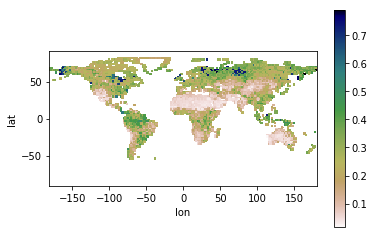

In [16]:
import xarray as xr
grid_lat = np.linspace(90, -90, 91)
grid_lon = np.linspace(-180, 180, 181)
data_arr = xr.DataArray(data, dims=['lat', 'lon'], coords=[lat[:, 0], lon[0, :]])
data_grid = data_arr.reindex({'lat': grid_lat, 'lon': grid_lon}, method='nearest')
figure()
data_grid.plot(cmap='gist_earth_r')
axis('scaled')

# Retrieve and plot SMAP data

* Over a date range
* With user-specified lat-lon points

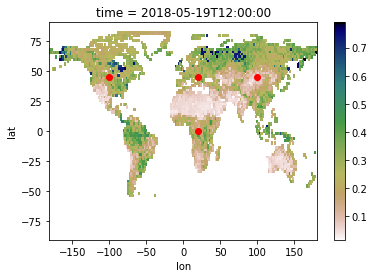

In [17]:
# Look at a list of points
lat_lon_pts = [
    (  45.0, 45.0,  0.0, 45.0),  # Lat
    (-100.0, 20.0, 20.0, 100.0), # Lon
]

# Turn the list into a numpy array
lat_lon_pts = np.array(lat_lon_pts)

# Let's plot the points
o.plot(cmap='gist_earth_r')
plot(lat_lon_pts[1], lat_lon_pts[0], 'ro')
pass

In [18]:
c_pts = podpac.Coordinates([lat_lon_pts,
                            podpac.crange('2018-05-15T00', '2018-05-19T00', '3,h')], 
                            dims=['lat_lon', 'time']
                          )

# run 6 parallel requests to complete faster
sm.threaded = True;
sm.n_threads = 6

ot = sm.eval(c_pts)
sm.threaded = False

INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T030000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[236:1:812][856:1:2999]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.18/SMAP_L4_SM_aup_20180518T030000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[236:1:812][856:1:2999]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.16/SMAP_L4_SM_aup_20180516T030000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[236:1:812][856:1:2999]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.17/SMAP_L4_SM_aup_20180517T030000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[236:1:812][856:1:2999]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T060000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[236:1:812][856:1:2999]


([<matplotlib.axis.XTick at 0x1e6b2fada90>,
 <a list of 5 Text xticklabel objects>)

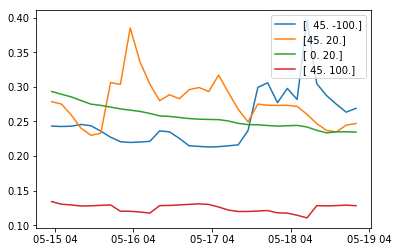

In [19]:
plot(ot.time, ot.data.T)
legend([str(llp) for llp in lat_lon_pts.T])
locs, labels = xticks()
xticks(locs[::2])
pass

# Let's do the same thing without using PODPAC

## Find the names of the source files

In [20]:
# I'm using PODPAC to help out
_, date_source_inds = sm.source_coordinates.intersect(c_pts, return_indices=True)
date_sources = sm.sources[date_source_inds]
sources = []
for ds in date_sources:
    _, inds = ds.source_coordinates.intersect(c_pts, return_indices=True)
    sources.append(ds.sources[inds])
sources = np.concatenate(sources)
print(len(sources))
source_urls = []
for s in sources:
    source_urls.append(s.source)
    print(source_urls[-1])

32
https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T030000_Vv4030_001.h5
https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T060000_Vv4030_001.h5
https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T090000_Vv4030_001.h5
https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T120000_Vv4030_001.h5
https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T150000_Vv4030_001.h5
https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T180000_Vv4030_001.h5
https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T210000_Vv4030_001.h5
https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180516T000000_Vv4030_001.h5
https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.16/SMAP_L4_SM_aup_20180516T0

## Find the nearest neighbor index for lat and lon for each point

In [21]:
dataset = pydap.client.open_url(source_urls[0], session=auth_session)
key = 'Analysis_Data_sm_surface_analysis'
lat_key = 'cell_lat'
lon_key = 'cell_lon'
lat = dataset[lat_key][:]
lon = dataset[lon_key][:]

INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T030000_Vv4030_001.h5.dods?cell_lat[0:1:1623][0:1:3855]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T030000_Vv4030_001.h5.dods?cell_lon[0:1:1623][0:1:3855]


In [22]:
inds = []
for pt in lat_lon_pts.T:
    lat_ind = np.argmin(np.abs(lat[:, 0] - pt[0]))
    lon_ind = np.argmin(np.abs(lon[0, :] - pt[1]))
    inds.append((lat_ind, lon_ind))
inds

[(236, 856), (236, 2142), (811, 2142), (236, 2999)]

## Loop through all the sources and retrieve the data

In [24]:
# This takes longer than before because there is no threading
data = []
for s in source_urls:
    dataset = pydap.client.open_url(s, session=auth_session)
    date_data = [np.array(dataset[key][int(ind[0]), int(ind[1])]).item() for ind in inds]
    data.append(date_data)

INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T030000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[236:1:236][856:1:856]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T030000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[236:1:236][2142:1:2142]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T030000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[811:1:811][2142:1:2142]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T030000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[236:1:236][2999:1:2999]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.15/SMAP_L4_SM_aup_20180515T060000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[236:1:236][856:1:856]

### Plot the results

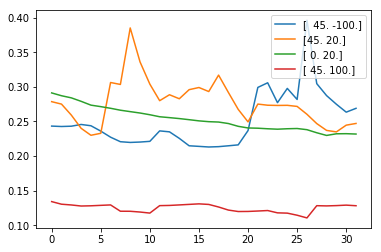

In [25]:
figure()
plot(data)
legend([str(llp) for llp in lat_lon_pts.T])

# Retrieve and plot SMAP data

* Over a particular date 
* Over lat-lon range with underlying, native SMAP coordinates
* Define a lat-lon bounding box for retrieving SMAP data

In [26]:
bbox = podpac.Coordinates([              # (start, stop, number)
                           podpac.clinspace(   49,   25, 2),  # lat
                           podpac.clinspace( -126,  -66, 2),  # lon
                          ], dims=['lat', 'lon']
)

## Get native coordinates of the SMAP data

In [27]:
# This next line computes the combined coordinates of the SMAP dataset
sm_nc = sm.find_coordinates()[0]  # find_coordinates always returns a list, but this only has one entry
sm_nc

Coordinates
	time: ArrayCoordinates1d(time): Bounds[2015-03-31T03:00:00, 2019-02-04T00:00:00], N[11248], ctype['point']
	lat: ArrayCoordinates1d(lat): Bounds[-84.65644073486328, 84.65644073486328], N[1624], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-179.95474243164062, 179.95474243164062], N[3856], ctype['midpoint']

In [28]:
# Get the SMAP native coordinates in the desired bounding box
c_intersect = sm_nc.intersect(bbox)
c_intersect = c_intersect.drop('time')
c_intersect

Coordinates
	lat: ArrayCoordinates1d(lat): Bounds[25.02339744567871, 48.95127868652344], N[271], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-125.98908996582031, -66.05409240722656], N[643], ctype['midpoint']

## Select a specific date and time

In [29]:
c = podpac.coordinates.merge_dims([podpac.Coordinates.grid(time='2017-04-30T21:00:00'), c_intersect])
c

Coordinates
	time: ArrayCoordinates1d(time): Bounds[2017-04-30T21:00:00, 2017-04-30T21:00:00], N[1], ctype['point']
	lat: ArrayCoordinates1d(lat): Bounds[25.02339744567871, 48.95127868652344], N[271], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-125.98908996582031, -66.05409240722656], N[643], ctype['midpoint']

## Retrieve and plot the data

INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2017.04.30/SMAP_L4_SM_aup_20170430T210000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[198:1:468][578:1:1220]


(-126.03593826293945,
 -66.00781631469727,
 24.984514236450195,
 49.00458335876465)

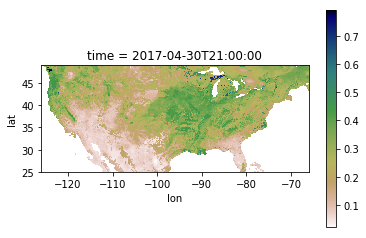

In [30]:
o = sm.eval(c)
figure()
o.plot(cmap='gist_earth_r')
axis('scaled')
pass

# Export pipeline for re-use elsewhere

In [31]:
print(sm.json_pretty)

{
    "nodes": {
        "SMAP_SPL4SMAU": {
            "node": "datalib.smap.SMAP",
            "attrs": {
                "base_url": "https://n5eil02u.ecs.nsidc.org/opendap/SMAP",
                "product": "SPL4SMAU",
                "version": 4
            },
            "interpolation": "nearest"
        }
    }
}
